In [2]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from IPython.display import clear_output
from scipy.optimize import curve_fit

# Fit full

In [6]:
N = 40
times = jnp.linspace(0, 5, 101)


def nbar_mesolve_full(
    lam: complex,
    alpha_2: float,
    kerr_o_kappa_2: float,
) -> float:
    a = dq.destroy(N)
    L_m = a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(N)
    H = kerr_o_kappa_2 * dq.dag(a) @ dq.dag(a) @ a @ a

    rho_0 = dq.fock(N, 0)
    output = dq.mesolve(H, [L_m], rho_0, times)
    return output.states

2024-08-19 11:02:42.461471: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
100%|██████████| 50/50 [00:02<00:00, 21.13it/s]


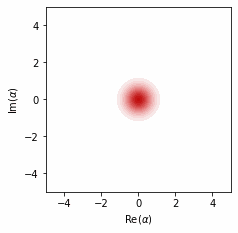

In [7]:
output = nbar_mesolve_full(0.1, 4.0, 0.5)
dq.plot_wigner_gif(output)

In [8]:
N = 20
times = jnp.linspace(0, 5, 101)


def nbar_mesolve_full_even(
    lam: complex,
    alpha_2: float,
    kerr_o_kappa_2: float,
) -> float:
    a = dq.destroy(2 * N)
    L_m = a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(2 * N)
    L_m = L_m[::2, ::2]
    H = kerr_o_kappa_2 * dq.dag(a) @ dq.dag(a) @ a @ a
    H = H[::2, ::2]

    rho_0 = dq.fock(N, 0)
    output = dq.mesolve(H, [L_m], rho_0, times)
    states = jnp.zeros((len(output.states), 2 * N, 2 * N), dtype=complex)
    states = states.at[:, ::2, ::2].set(output.states)
    return states

|██████████| 100.0% ◆ total 0.66s ◆ remaining 00:00
100%|██████████| 50/50 [00:02<00:00, 21.93it/s]


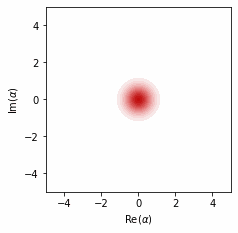

In [9]:
output = nbar_mesolve_full_even(0.1, 4.0, 0.5)
dq.plot_wigner_gif(output)

# Fit function

In [5]:
def _one_nbars(
    lam: complex,
    alpha_2: float,
    kerr_o_kappa_2: float,
) -> float:
    a = dq.destroy(2 * N)
    L_m = (a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(2 * N))[::2, ::2]
    H = (kerr_o_kappa_2 * dq.dag(a) @ dq.dag(a) @ a @ a)[::2, ::2]
    nb = (dq.dag(a) @ a)[::2, ::2]

    rho_0 = dq.fock(N, 0)
    output = dq.mesolve(H, [L_m], rho_0, times, exp_ops=[nb])
    return output.expects[0, -1].real

In [11]:
def _one_cost(
    params: dict[str, float],
    lam_phase: float,
    nbar: float,
) -> float:
    lam = params["lam_abs"] * jnp.exp(1j * (lam_phase - params["lam_phase_offset"]))
    a = dq.destroy(2 * N)
    L_m = (a @ a + lam * dq.dag(a) @ a - params["alpha_2"] * dq.eye(2 * N))[::2, ::2]
    H = (params["kerr_o_kappa_2"] * dq.dag(a) @ dq.dag(a) @ a @ a)[::2, ::2]
    nb = (dq.dag(a) @ a)[::2, ::2]

    rho_0 = dq.fock(N, 0)
    output = dq.mesolve(H, [L_m], rho_0, times, exp_ops=[nb])
    return (output.expects[0, -1].real - nbar) ** 2

In [12]:
def _all_cost(params: dict[str, float], lam_phases: jax.Array, nbars: jax.Array):
    return jax.vmap(jax.value_and_grad(_one_cost), in_axes=(None, 0, 0))(
        params, lam_phases, nbars
    )

In [13]:
def cost_fn_val_and_grad(
    params: dict[str, float], lam_phase: jax.Array, nbars: jax.Array
):
    cost, cost_grads = _all_cost(params, lam_phase, nbars)
    for k in cost_grads:
        cost_grads[k] = jnp.nan_to_num(cost_grads[k], nan=0.0)
        cost_grads[k] = jnp.sum(cost_grads[k])
    return jnp.sum(cost), cost_grads

In [14]:
N = 20
times = jnp.linspace(0, 5, 101)
params = {
    "lam_phase_offset": 0.5,
    "lam_abs": 0.5,
    "alpha_2": 4.0,
    "kerr_o_kappa_2": 0.0,
}
phases = jnp.linspace(-jnp.pi, jnp.pi, 11)
cost_fn_val_and_grad(params, phases, jnp.zeros(len(phases)))

|██████████| 100.0% ◆ total 1.91s ◆ remaining 00:00


(Array(317.52463, dtype=float32),
 {'alpha_2': Array(151.55865, dtype=float32),
  'kerr_o_kappa_2': Array(-0.00248877, dtype=float32),
  'lam_abs': Array(839.0862, dtype=float32),
  'lam_phase_offset': Array(-18.879879, dtype=float32)})

# Loading data

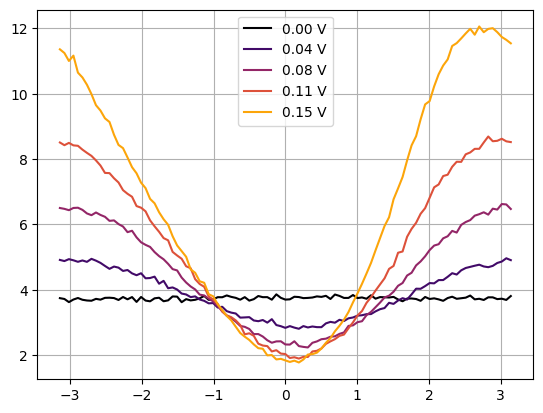

In [15]:
data = np.load("data_to_fit_phase_cal.npy", allow_pickle=True).item()
phase_buf = jnp.array(data["phase"])
nbars = jnp.array(data["nbars"])
amps_V = jnp.array(data["amps_V"])

fig, ax = plt.subplots()
colors = plt.get_cmap("inferno")(np.linspace(0, 0.8, len(nbars)))
for i, (nb, amp_V) in enumerate(zip(nbars, amps_V)):
    ax.plot(phase_buf, nb, color=colors[i], label=f"{amp_V:.2f} V")
ax.grid(True)
ax.legend()
plt.show()

# Fitting one curve

In [16]:
N = 35
N_iter = 100
times = jnp.linspace(0, 5, 101)
ind_fit = -1
params = {
    "lam_phase_offset": 0.0,
    "lam_abs": 0.8,
    "alpha_2": 3.7,
    "kerr_o_kappa_2": -15 / 400,
}
vmins = jnp.array([-jnp.pi, 0.0, 0.0, -0.5])
vmaxs = jnp.array([jnp.pi, 2.0, 10.0, 0.5])

N_optimize = 100
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(params)
costs, popts = [], [params]

In [ ]:
for _ind in range(N_iter):
    cost, cost_grad = cost_fn_val_and_grad(popts[-1], phase_buf, nbars[ind_fit])
    updates, optimizer_state = optimizer.update(cost_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    params = {
        k: jnp.clip(v, vmin, vmax)
        for (k, v), vmin, vmax in zip(params.items(), vmins, vmaxs)
    }
    costs.append(cost)
    popts.append(params)

    clear_output(wait=True)
    print(cost_grad)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].plot(phase_buf, nbars[ind_fit], label="Data")
    lams = popts[-1]["lam_abs"] * jnp.exp(
        1j * (phase_buf - popts[-1]["lam_phase_offset"])
    )
    nbars_fit = jax.vmap(_one_nbars, in_axes=(0, None, None))(
        lams, popts[-1]["alpha_2"], popts[-1]["kerr_o_kappa_2"]
    )
    ax[0].plot(phase_buf, nbars_fit, label="Fit")
    ax[0].legend()
    ax[0].grid(True)
    ax[0].set_xlabel("Phase")
    ax[0].set_ylabel("nbar")
    ax[1].plot(costs)
    ax[1].grid(True)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Cost")

    fig.suptitle(
        f'Iteration: {_ind + 1}/{N_iter} | Cost: {cost:.2e} |\n'
        f'$\\theta$ = {popts[-1]["lam_phase_offset"]/np.pi:.2f} $\\pi$ | '
        f'$|\\lambda| = {popts[-1]["lam_abs"]:.2f}$ | '
        f'$\\alpha_2 = {popts[-1]["alpha_2"]:.2f}$ | '
        f'$K/\\kappa_2 = {popts[-1]["kerr_o_kappa_2"]:.2f}$'
    )
    fig.tight_layout()
    plt.show()

# Curve fit

In [4]:
def fit_function(phase, lam_phase_offset, lam_abs, alpha_2, kerr_o_kappa_2):
    lams = lam_abs * jnp.exp(1j * (phase - lam_phase_offset))
    nbars_fit = jax.vmap(_one_nbars, in_axes=(0, None, None))(
        lams, alpha_2, kerr_o_kappa_2
    )
    return nbars_fit

In [27]:
N = 40
times = jnp.linspace(0, 5, 101)
ind_fit = -1
guess = [0.0, 0.8, 3.7, -15 / 400]

|██████████| 100.0% ◆ total 11.84s ◆ remaining 00:00


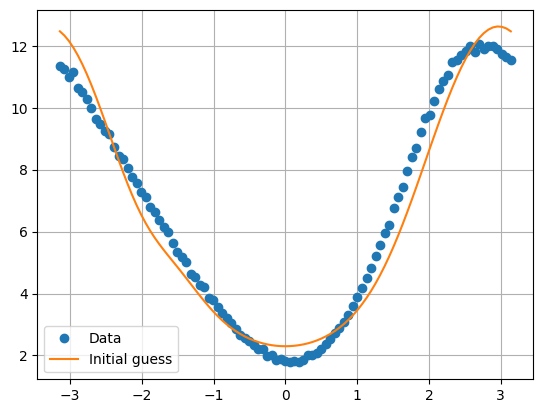

In [28]:
fig, ax = plt.subplots()
ax.plot(phase_buf, nbars[ind_fit], "o", label="Data")
ax.plot(phase_buf, fit_function(phase_buf, *guess), label="Initial guess")
ax.grid(True)
ax.legend()
plt.show()

In [29]:
popt, pcovs = curve_fit(
    fit_function,
    phase_buf,
    nbars[ind_fit],
    p0=guess,
    bounds=([-jnp.pi, 0.0, 0.0, -0.5], [jnp.pi, 2.0, 10.0, 0.5]),
)[:2]

|██████████| 100.0% ◆ total 11.89s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.96s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.94s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.87s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.93s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.34s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.34s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.42s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.37s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.63s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.58s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.52s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.57s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.48s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.50s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.55s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.56s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.61s ◆ remaining

In [33]:
popt, guess

(array([-0.13652885,  0.75021108,  4.12793882, -0.04304622]),
 [0.0, 0.8, 3.7, -0.0375])

|██████████| 100.0% ◆ total 11.93s ◆ remaining 00:00
|██████████| 100.0% ◆ total 11.47s ◆ remaining 00:00


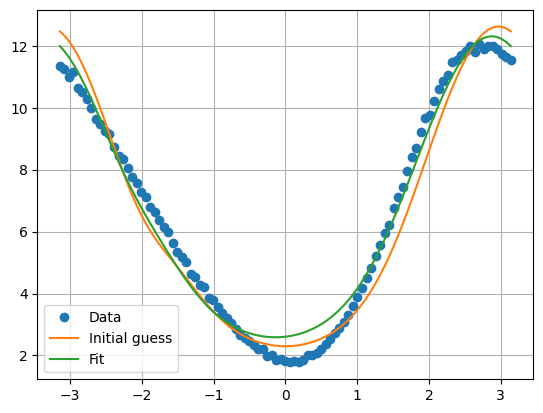

In [31]:
fig, ax = plt.subplots()
ax.plot(phase_buf, nbars[ind_fit], "o", label="Data")
ax.plot(phase_buf, fit_function(phase_buf, *guess), label="Initial guess")
ax.plot(phase_buf, fit_function(phase_buf, *popt), label="Fit")
ax.grid(True)
ax.legend()
plt.show()

In [30]:
popts

[{'lam_phase_offset': 0.0,
  'lam_abs': 0.8,
  'alpha_2': 3.7,
  'kerr_o_kappa_2': -0.0375}]

# Adding Kerr to low nbar fit

In [175]:
def _one_nbars(lam: complex, alpha_2: float, kerr_o_kappa_2: float) -> float:
    a = dq.destroy(2 * N)
    L_m = (a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(2 * N))[::2, ::2]
    H = (-kerr_o_kappa_2 / 2 * dq.dag(a) @ dq.dag(a) @ a @ a)[::2, ::2]
    nb = (dq.dag(a) @ a)[::2, ::2]

    rho_0 = dq.coherent(2 * N, jnp.sqrt(alpha_2)) + dq.coherent(
        2 * N, -jnp.sqrt(alpha_2)
    )
    rho_0 = dq.todm(dq.unit(rho_0))[::2, ::2]
    output = dq.mesolve(H, [L_m], rho_0, times, exp_ops=[nb])

    # return output.expects[0, -1].real
    # full_states = jnp.zeros((len(output.states), 2 * N, 2 * N), dtype=complex)
    # full_states = full_states.at[:, ::2, ::2].set(output.states)
    # plt.plot(output.expects[0].real)
    # dq.plot_wigner_gif(full_states)

    # a = dq.destroy(N)
    # L_m = a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(N)
    # H = -kerr_o_kappa_2 / 2 * dq.dag(a) @ dq.dag(a) @ a @ a
    # nb = dq.dag(a) @ a

    # rho_0 = dq.coherent(N, jnp.sqrt(alpha_2)) + dq.coherent(N, -jnp.sqrt(alpha_2))
    # rho_0 = dq.todm(dq.unit(rho_0))
    # output = dq.mesolve(H, [L_m], rho_0, times, exp_ops=[nb])
    return output.expects[0, -1].real

In [123]:
N = 40
times = jnp.linspace(0, 2, 11)
_one_nbars(0.6 * jnp.exp(-1j * np.pi / 2), 4, 0)

|          |   1.0% ◆ total 0.01s ◆ remaining 00:00

|██████████| 100.0% ◆ total 2.90s ◆ remaining 00:00


Array(4.997965, dtype=float32)

In [176]:
def fit_function(phase, lam_phase_offset, lam_abs, alpha_2, kerr_o_kappa_2):
    lams = lam_abs * jnp.exp(1j * (phase - lam_phase_offset))
    nbars_fit = jax.vmap(_one_nbars, in_axes=(0, None, None))(
        lams, alpha_2, kerr_o_kappa_2
    )
    return nbars_fit

In [177]:
data = np.load("data_to_fit_phase_cal.npy", allow_pickle=True).item()
phase_buf = jnp.array(data["phase"])
nbars = jnp.array(data["nbars"])
amps_V = jnp.array(data["amps_V"])
popts = np.array(data["popts"])
phase_buf_fit = phase_buf  # np.linspace(-np.pi, np.pi, 11)

In [188]:
popts

array([[0.        , 0.        , 3.67326221],
       [0.18117078, 0.19419877, 3.40894739],
       [0.13635209, 0.46006667, 3.28215732],
       [0.12135088, 0.81109557, 3.38469197],
       [0.05872929, 1.04259237, 3.35852985]])

In [198]:
# popts[:, 2] = np.array([3.67326221, 3.67063178, 3.67063178, 3.67063178, 3.67063178])
# popts[:, 1] = np.array([0.0, 0.27933983, 0.60882153, 0.93018084, 1.16212589])

popts[:, 2] = np.array([3.67326221, 3.40894739, 3.28215732, 3.38469197, 3.35852985])
popts[:, 1] = np.array([0.0, 0.19419877, 0.46006667, 0.81109557, 1.04259237])

In [199]:
N = 20
times = jnp.linspace(0, 2, 11)
kerr_o_kappa_2 = 15 / 375
delta_o_kappa_2 = 0.0
popts = np.array(data["popts"])

fits_no_kerr = np.zeros((len(nbars), len(phase_buf_fit)))
# for ind in range(5):
#     fits_no_kerr[ind] = fit_function(phase_buf_fit, *popts[ind], 0)

# popts[0, 2] += 0.05
# popts[1, 1] += 0.02
# popts[1, 1] += 0.02

fits = np.zeros((len(nbars), len(phase_buf_fit)))
for ind in range(3):
    fits[ind] = fit_function(phase_buf_fit, *popts[ind], kerr_o_kappa_2)

|▋         |   6.5% ◆ total 0.01s ◆ remaining 00:00

|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.48s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.60s ◆ remaining 00:00


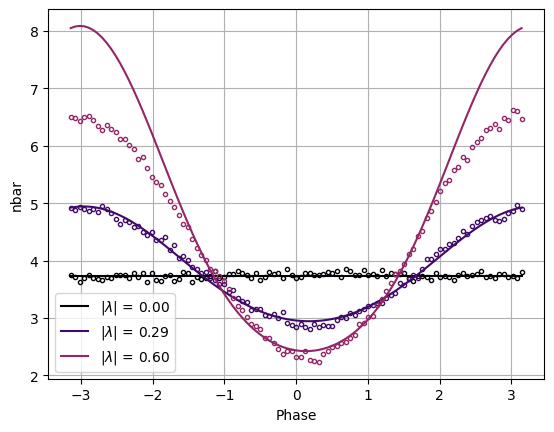

In [200]:
fig, ax = plt.subplots()
colors = plt.get_cmap("inferno")(np.linspace(0, 0.8, len(nbars)))
for i, (nb, ft, ft_no_kerr, popt) in enumerate(
    zip(nbars[:3], fits, fits_no_kerr, popts)
):
    ax.plot(phase_buf, nb, ".", fillstyle="none", color=colors[i])
    ax.plot(
        phase_buf_fit,
        ft,
        "-",
        fillstyle="none",
        color=colors[i],
        label=f"$|\\lambda|$ = {popt[1]:.2f}",
    )
    # ax.plot(
    #     phase_buf_fit,
    #     ft_no_kerr,
    #     "v-",
    #     fillstyle="none",
    #     color=colors[i],
    #     label=f"$|\\lambda|$ = {popt[1]:.2f} no $K_4$",
    # )
ax.grid(True)
ax.legend()
ax.set_xlabel("Phase")
ax.set_ylabel("nbar")
plt.show()

## Fit fit fixed Kerr 

In [156]:
def _one_nbars(lam: complex, alpha_2: float, kerr_o_kappa_2: float) -> float:
    a = dq.destroy(2 * N)
    L_m = (a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(2 * N))[::2, ::2]
    H = (-kerr_o_kappa_2 / 2 * dq.dag(a) @ dq.dag(a) @ a @ a)[::2, ::2]
    nb = (dq.dag(a) @ a)[::2, ::2]

    rho_0 = dq.coherent(2 * N, jnp.sqrt(alpha_2)) + dq.coherent(
        2 * N, -jnp.sqrt(alpha_2)
    )
    rho_0 = dq.todm(dq.unit(rho_0))[::2, ::2]
    output = dq.mesolve(H, [L_m], rho_0, times, exp_ops=[nb])
    return output.expects[0, -1].real

In [157]:
def fit_function(phase, lam_phase_offset, lam_abs, alpha_2):
    lams = lam_abs * jnp.exp(1j * (phase - lam_phase_offset))
    nbars_fit = jax.vmap(_one_nbars, in_axes=(0, None, None))(
        lams, alpha_2, kerr_o_kappa_2
    )
    return nbars_fit

In [158]:
def fit_function_lambda_0(phase_buf, alpha_2):
    nbars_fit = jax.vmap(_one_nbars, in_axes=(0, None, None))(
        jnp.zeros_like(phase_buf), alpha_2, kerr_o_kappa_2
    )
    return nbars_fit

In [159]:
data = np.load("data_to_fit_phase_cal.npy", allow_pickle=True).item()
phase_buf = jnp.array(data["phase"])
nbars = jnp.array(data["nbars"])[:3]
amps_V = jnp.array(data["amps_V"])
popts = np.array(data["popts"])
sigmas = np.array(data["sigmas"])

In [160]:
N = 20
times = jnp.linspace(0, 2, 11)
kerr_o_kappa_2 = 14 / 375
popts_kerr = np.zeros_like(data["popts"])
pcovs_kerr = np.zeros((len(nbars), 3, 3))
fit_values = np.zeros((len(nbars), len(phase_buf)))
for ind_fit in range(3):
    if ind_fit == 0:
        guess = [popts[ind_fit, 2]]
        popt, pcovs = curve_fit(
            fit_function_lambda_0,
            phase_buf,
            nbars[ind_fit],
            p0=guess,
            bounds=([0.0], [10.0]),
            sigma=sigmas[ind_fit],
        )[:2]
        popts_kerr[ind_fit, 2] = popt[0]
        pcovs_kerr[ind_fit, 2, 2] = pcovs[0, 0]
        fit_values[ind_fit] = fit_function_lambda_0(phase_buf, *popt)
    else:
        guess = popts[ind_fit]
        popt, pcovs = curve_fit(
            fit_function,
            phase_buf,
            nbars[ind_fit],
            p0=guess,
            bounds=([-jnp.pi, 0.0, 3.0], [jnp.pi, 2, 5.0]),
            sigma=nbars[ind_fit] ** 2,
        )[:2]
        popts_kerr[ind_fit] = popt
        pcovs_kerr[ind_fit] = pcovs
        fit_values[ind_fit] = fit_function(phase_buf, *popt)

|          |   0.5% ◆ total 0.00s ◆ remaining 00:00

|██████████| 100.0% ◆ total 0.37s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.36s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.47s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.47s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.47s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.47s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.47s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.48s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.47s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.47s ◆ remaining 00:00
|██████████|

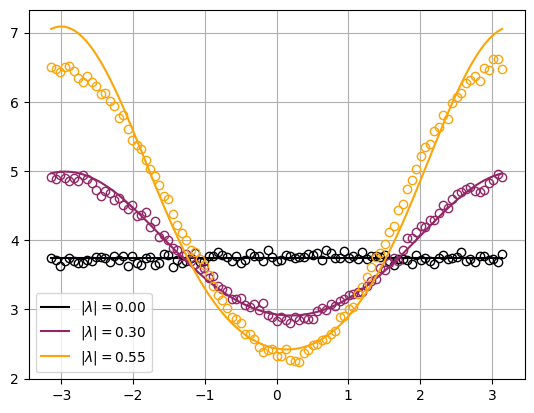

In [168]:
fig, ax = plt.subplots()
colors = plt.get_cmap("inferno")(np.linspace(0, 0.8, len(nbars)))
for ind in range(3):
    ax.plot(phase_buf, nbars[ind], "o", fillstyle="none", color=colors[ind])
    ax.plot(
        phase_buf,
        fit_values[ind],
        label=f"$|\\lambda| = {popts_kerr[ind, 1]:.2f}$",
        color=colors[ind],
    )
ax.grid(True)
ax.legend()
plt.show()

In [202]:
popts_kerr, pcovs_kerr

(array([[0.        , 0.        , 3.74506015],
        [0.19599228, 0.30225577, 3.6432634 ],
        [0.1431355 , 0.55322498, 3.47208367],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]),
 array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  2.58130616e-05]],
 
        [[ 1.10284606e-04, -3.62126070e-07, -3.33488863e-08],
         [-3.62126070e-07,  8.57131997e-06, -3.31755784e-06],
         [-3.33488863e-08, -3.31755784e-06,  5.06755890e-05]],
 
        [[ 2.21965844e-04, -2.57015572e-06,  1.89787408e-06],
         [-2.57015572e-06,  3.92373819e-05, -2.97257189e-05],
         [ 1.89787408e-06, -2.97257189e-05,  3.35512185e-04]]]))

In [203]:
results_fit = {
    "popts_kerr": popts_kerr,
    "pcovs_kerr": pcovs_kerr,
    "fit_values": fit_values,
}
np.save("results_fit_phase_cal.npy", results_fit)

# Computing Wigners

In [216]:
def _one_wigner(lam: complex, alpha_2: float, kerr_o_kappa_2: float, p: float) -> float:
    a = dq.destroy(N)
    L_m = a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(N)
    H = -kerr_o_kappa_2 / 2 * dq.dag(a) @ dq.dag(a) @ a @ a

    cat_p = dq.coherent(N, jnp.sqrt(alpha_2)) + dq.coherent(N, -jnp.sqrt(alpha_2))
    cat_m = dq.coherent(N, jnp.sqrt(alpha_2)) - dq.coherent(N, -jnp.sqrt(alpha_2))
    rho_0 = p * dq.todm(dq.unit(cat_p)) + (1 - p) * dq.todm(dq.unit(cat_m))
    output = dq.mesolve(H, [L_m], rho_0, times)
    return output.states[-1]

|█████▏    |  52.5% ◆ total 0.06s ◆ remaining 00:00

|██████████| 100.0% ◆ total 0.11s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.10s ◆ remaining 00:00


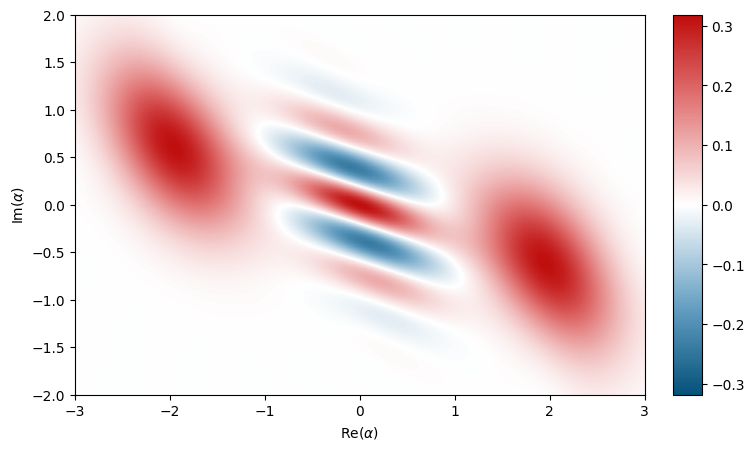

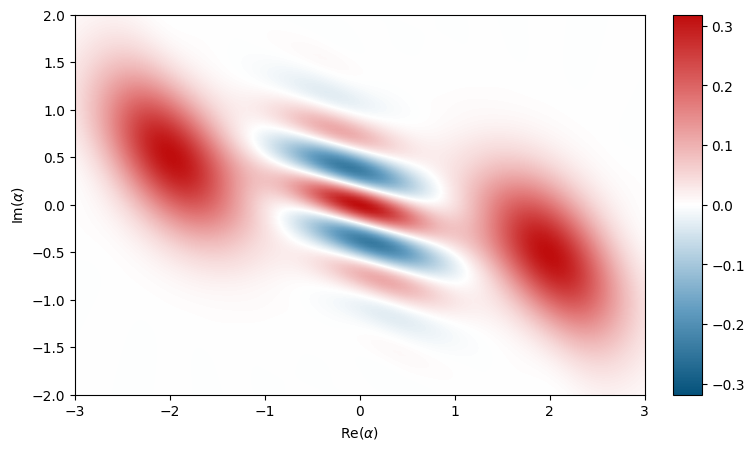

In [225]:
phase_corr = -0.1 * jnp.pi
state = _one_wigner(
    0.55 * np.exp(1j * (np.pi / 2 + phase_corr)),
    3.8 * jnp.exp(1j * phase_corr),
    60 / 375,
    0.75,
)
dq.plot_wigner(state, vmax=1 / jnp.pi, xmax=3, ymax=2)
state = _one_wigner(0.55 * np.exp(1j * np.pi / 2), 3.7, 0 / 375, 0.75)
dq.plot_wigner(state, vmax=1 / jnp.pi, xmax=3, ymax=2)